In [1]:
## Bibliotecas para tratamento de dados, plotting e leitura de arquivos de dados
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob

## Geopandas: Utilizamos para conseguir ler arquivos do tipo Shape (.shp) 
import geopandas as gpd

## Pacotes PySAL
# libpysal: Biblioteca core do PySAL. Utilizamos o método de vizinhança Queen
from libpysal.weights.contiguity import Queen
# ESDA (Exploratory Spatial Data Analysis): utilizamos para o cálculo de correlação
from esda.moran import Moran_Local, Moran_BV, Moran_Local_BV
# SPlot: Utilizamos para fazer os plots espaciais
from splot.esda import moran_scatterplot, plot_local_autocorrelation, lisa_cluster, plot_moran_bv

# Para exibirmos várias linhas e colunas
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

In [3]:
MAPAS_PATH = "BR_UF_2020/"
DATA_PATH = "Histórico de Dados Meteorológicos - 2021/"

## Computamos as vizinhanças e pesos

Carregamos o shape file

<AxesSubplot:>

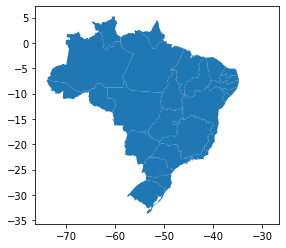

In [4]:
gdf = gpd.read_file(MAPAS_PATH + "BR_UF_2020.shp")
gdf.plot()

In [5]:
gdf

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry
0,11,Rondônia,RO,Norte,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4..."
1,12,Acre,AC,Norte,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828..."
2,13,Amazonas,AM,Norte,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620..."
3,14,Roraima,RR,Norte,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416..."
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ..."
5,16,Amapá,AP,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2..."
6,17,Tocantins,TO,Norte,"POLYGON ((-48.23291 -5.94757, -48.23163 -5.946..."
7,21,Maranhão,MA,Nordeste,"MULTIPOLYGON (((-44.96620 -1.27114, -44.96081 ..."
8,22,Piauí,PI,Nordeste,"POLYGON ((-42.91509 -6.64795, -42.91636 -6.644..."
9,23,Ceará,CE,Nordeste,"POLYGON ((-41.18292 -4.01797, -41.18552 -4.017..."


Aqui setamos o tipo de contiguidade que desejamos. Existem dois tipos predefinidos para definir vizinhança, que são o `Rook` e o `Queen`. A contiguidade `Rook` considera vizinhos aquelas regiões que têm bordas em comum. A contiguidade `Queen` é uma extensão da contiguidade `Rook` que considera também como vizinhas aquelas regiões cuja borda contém somente um ponto em comum. O nome vem das peças do jogo de xadrez, e os métodos têm bastante diferença quando nossas regiões estão dispostas em _grid_ [[1]](#refs).

Aqui, vamos considerar o método `Queen` para calcular a matriz de contiguidade, mas o método `Rook` também poderia ser utilizado.

O resultado é uma matriz esparsa binária, indicando se uma região é vizinha de outra (1) ou não (0).

In [6]:
weights = Queen.from_dataframe(gdf)

In [7]:
W_matrix, ids = weights.full()

In [8]:
list(W_matrix[0]) # notar que é uma matriz de 0's e 1's

[0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0]

Vamos também normalizar a matriz por linhas (`r`) usando a função `transform` [[2]](#refs).

In [9]:
weights.transform = 'r'

In [10]:
W_matrix, ids = weights.full()

In [11]:
list(W_matrix[0]) # notar que é os 1's foram normalizados

[0.0,
 0.3333333333333333,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.0,
 0.0]

Vemos quantos não zeros temos na matriz.

In [13]:
str(np.round(weights.pct_nonzero, 2)) + "%"

'13.99%'

Vemos quantas regiões temos (`n`). Nossa matriz tem `n * n` valores.

In [14]:
weights.n

27

Ou seja, temos 27 UFs no Brasil (26 estados mais o Distrito Federal).

## Preparamos os dados de pluviometria

Vamos carregar os dados meteorológicos de todas as cidades brasileiras disponíveis.

In [50]:
df_meteorologicos = pd.DataFrame()

In [51]:
meteo_file_paths = glob.glob(DATA_PATH + "INMET*.CSV")
meteo_file_paths

['Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A001_BRASILIA_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A042_BRAZLANDIA_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A002_GOIANIA_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A003_MORRINHOS_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A005_PORANGATU_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A011_SAO SIMAO_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A012_LUZIANIA_

In [52]:
for path in meteo_file_paths:
    try:
        print(f"Lendo arquivo {path}...")
        df_file = pd.read_csv(path, encoding="ISO-8859-1", sep=";", header=8)
        print(f"Arquivo {path} lido com sucesso!")
        # Adicionamos as informações da cidade e do estado, presentes no nome do arquivo
        filename = path.split('\\')[1]
        region = filename.split("_")[1]
        uf = filename.split("_")[2]
        city = filename.split("_")[4]
        print(f"Arquivo referente a {uf} - {city}")
        df_file["Região"] = region
        df_file["UF"] = uf
        df_file["Cidade"] = city
        df_meteorologicos = pd.concat([df_meteorologicos, df_file])
        print(f"Shape final: {df_meteorologicos.shape}")
    except Exception as e:
        print(f"Falha ao ler arquivo {path} :-(")
        print(e)
    print()

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A001_BRASILIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A001_BRASILIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a DF - BRASILIA
Shape final: (2880, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A042_BRAZLANDIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A042_BRAZLANDIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a DF - BRAZLANDIA
Shape final: (5760, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a DF - AGUAS EMENDADAS
Shape final: (8640, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A703_PONTA PORA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - PONTA PORA
Shape final: (95040, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A704_TRES LAGOAS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A704_TRES LAGOAS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - TRES LAGOAS
Shape final: (97920, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A709_IVINHEMA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A709_IVINHEMA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - IVINHEMA
Shape final: (100800, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A710_PARANAIBA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A710_PARANAIBA_01-01-2021_A_30-04-2021.CSV li

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S702_ARAL MOREIRA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - ARAL MOREIRA
Shape final: (175680, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S703_BANDEIRANTES_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S703_BANDEIRANTES_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - BANDEIRANTES
Shape final: (178560, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S704_BONITO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S704_BONITO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - BONITO
Shape final: (181440, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S705_BRASILANDIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S705_BRASILANDIA_01-01-2021_A_30-04-2021

Shape final: (264960, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A919_COTRIGUACU_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A919_COTRIGUACU_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MT - COTRIGUACU
Shape final: (267840, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A920_JUINA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A920_JUINA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MT - JUINA
Shape final: (270720, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A921_SAO FELIX  DO ARAGUAIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A921_SAO FELIX  DO ARAGUAIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MT - SAO FELIX  DO ARAGUAIA
Shape final: (273600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 20

Shape final: (345600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A401_SALVADOR_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A401_SALVADOR_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - SALVADOR
Shape final: (348480, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A402_BARREIRAS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A402_BARREIRAS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - BARREIRAS
Shape final: (351360, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A404_LUIZ EDUARDO MAGALHAES_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A404_LUIZ EDUARDO MAGALHAES_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - LUIZ EDUARDO MAGALHAES
Shape final: (354240, 23)

Lendo arquivo Histórico de Dados Meteorológico

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A438_MARAU_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - MARAU
Shape final: (434880, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A439_IBOTIRAMA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A439_IBOTIRAMA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - IBOTIRAMA
Shape final: (437760, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A440_JACOBINA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A440_JACOBINA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - JACOBINA
Shape final: (440640, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A441_SERRINHA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A441_SERRINHA_01-01-2021_A_30-04-2021.CSV lido com sucesso!


Shape final: (518400, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A360_ACARAU_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A360_ACARAU_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a CE - ACARAU
Shape final: (521280, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A368_TIANGUA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A368_TIANGUA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a CE - TIANGUA
Shape final: (524160, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A369_QUIXADA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A369_QUIXADA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a CE - QUIXADA
Shape final: (527040, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_MA_A203_SAO LUIS_01-01-2021_A_30-04-202

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A373_ITAPORANGA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PB - ITAPORANGA
Shape final: (601920, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PE_A301_RECIFE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PE_A301_RECIFE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PE - RECIFE
Shape final: (604800, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PE_A307_PETROLINA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PE_A307_PETROLINA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PE - PETROLINA
Shape final: (607680, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PE_A309_ARCO VERDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PE_A309_ARCO VERDE_01-01-2021_A_30-04-2021.CSV lido com s

Shape final: (685440, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A365_CANTO DO BURITI_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A365_CANTO DO BURITI_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PI - CANTO DO BURITI
Shape final: (688320, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A374_CORRENTE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A374_CORRENTE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PI - CORRENTE
Shape final: (691200, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A375_BAIXA GRANDE DO RIBEIRO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A375_BAIXA GRANDE DO RIBEIRO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PI - BAIXA GRANDE DO RIBEIRO
Shape final: (694080, 23)

Lendo arquivo Histórico d

Shape final: (766080, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AM_A101_MANAUS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AM_A101_MANAUS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AM - MANAUS
Shape final: (768960, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AM_A109_EIRUNEPE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AM_A109_EIRUNEPE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AM - EIRUNEPE
Shape final: (771840, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AM_A110_BOCA DO ACRE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AM_A110_BOCA DO ACRE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AM - BOCA DO ACRE
Shape final: (774720, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AM_A111_LABREA_01-01-2021_A_

Shape final: (846720, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A212_PARAGOMINAS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A212_PARAGOMINAS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PA - PARAGOMINAS
Shape final: (849600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A213_TOME ACU_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A213_TOME ACU_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PA - TOME ACU
Shape final: (852480, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A214_RONDON DO PARA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A214_RONDON DO PARA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PA - RONDON DO PARA
Shape final: (855360, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A215

Shape final: (927360, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_RO_A938_VILHENA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_RO_A938_VILHENA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RO - VILHENA
Shape final: (930240, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_RO_A939_CACOAL_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_RO_A939_CACOAL_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RO - CACOAL
Shape final: (933120, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_RO_A940_ARIQUEMES_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_RO_A940_ARIQUEMES_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RO - ARIQUEMES
Shape final: (936000, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_RR_A135_BOA VISTA_01-01-2021_A_30-04-202

Shape final: (1008000, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_ES_A616_SAO MATEUS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_ES_A616_SAO MATEUS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a ES - SAO MATEUS
Shape final: (1010880, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_ES_A617_ALEGRE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_ES_A617_ALEGRE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a ES - ALEGRE
Shape final: (1013760, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_ES_A622_PRES. KENNEDY_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_ES_A622_PRES. KENNEDY_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a ES - PRES. KENNEDY
Shape final: (1016640, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_ES_A623_

Shape final: (1088640, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A523_PATROCINIO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A523_PATROCINIO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - PATROCINIO
Shape final: (1091520, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A524_FORMIGA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A524_FORMIGA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - FORMIGA
Shape final: (1094400, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A525_SACRAMENTO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A525_SACRAMENTO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - SACRAMENTO
Shape final: (1097280, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A526_MONTAL

Shape final: (1169280, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A551_RIO PARDO DE MINAS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A551_RIO PARDO DE MINAS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - RIO PARDO DE MINAS
Shape final: (1172160, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A552_SALINAS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A552_SALINAS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - SALINAS
Shape final: (1175040, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A553_JOAO PINHEIRO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A553_JOAO PINHEIRO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - JOAO PINHEIRO
Shape final: (1177920, 23)

Lendo arquivo Histórico de Dados Meteorológic

Shape final: (1247040, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A609_RESENDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A609_RESENDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RJ - RESENDE
Shape final: (1249920, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A610_PICO DO COUTO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A610_PICO DO COUTO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RJ - PICO DO COUTO
Shape final: (1252800, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A611_VALENCA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A611_VALENCA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RJ - VALENCA
Shape final: (1255680, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A618_TERESO

Shape final: (1321920, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A713_SOROCABA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A713_SOROCABA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - SOROCABA
Shape final: (1324800, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A714_ITAPEVA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A714_ITAPEVA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - ITAPEVA
Shape final: (1327680, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A715_SAO MIGUEL ARCANJO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A715_SAO MIGUEL ARCANJO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - SAO MIGUEL ARCANJO
Shape final: (1330560, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET

Shape final: (1402560, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A765_BERTIOGA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A765_BERTIOGA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - BERTIOGA
Shape final: (1405440, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A766_REGISTRO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A766_REGISTRO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - REGISTRO
Shape final: (1408320, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A767_SAO SEBASTIAO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A767_SAO SEBASTIAO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - SAO SEBASTIAO
Shape final: (1411200, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A768_

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A874_SAO MATEUS DO SUL_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PR - SAO MATEUS DO SUL
Shape final: (1486080, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A875_GENERAL CARNEIRO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A875_GENERAL CARNEIRO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PR - GENERAL CARNEIRO
Shape final: (1488960, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A876_CLEVELANDIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A876_CLEVELANDIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PR - CLEVELANDIA
Shape final: (1491840, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_B803_CAMPINA DA LAGOA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_B8

Shape final: (1563840, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A838_CAMAQUA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A838_CAMAQUA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RS - CAMAQUA
Shape final: (1566720, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A839_PASSO FUNDO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A839_PASSO FUNDO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RS - PASSO FUNDO
Shape final: (1569600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A840_BENTO GONCALVES_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A840_BENTO GONCALVES_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RS - BENTO GONCALVES
Shape final: (1572480, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_

Shape final: (1641600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_SC_A841_JOACABA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_SC_A841_JOACABA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SC - JOACABA
Shape final: (1644480, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_SC_A845_BOM JARDIM DA SERRA - MORRO DA IGREJA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_SC_A845_BOM JARDIM DA SERRA - MORRO DA IGREJA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SC - BOM JARDIM DA SERRA - MORRO DA IGREJA
Shape final: (1647360, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_SC_A848_DIONISIO CERQUEIRA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_SC_A848_DIONISIO CERQUEIRA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SC - DIONISIO CERQUEIRA
Shape f

In [53]:
df_meteorologicos.head()

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,Região,UF,Cidade
0,2021/01/01,0000 UTC,0,"887,1","887,1","886,3",NaN,"20,9","15,9","22,4","20,8","16,5","15,4",75.0,67.0,73.0,327.0,"3,6",",8",NaN,CO,DF,BRASILIA
1,2021/01/01,0100 UTC,0,"887,3","887,5","887,1",NaN,"20,5","16,4","21,1","19,5","16,9",16,83.0,73.0,78.0,134.0,"2,3","1,5",NaN,CO,DF,BRASILIA
2,2021/01/01,0200 UTC,0,"887,9",888,"887,2",NaN,"19,6","16,1","21,4","19,6","16,5","15,9",80.0,73.0,80.0,309.0,"2,5","1,1",NaN,CO,DF,BRASILIA
3,2021/01/01,0300 UTC,0,"887,6",888,"887,6",NaN,"19,4","16,7","20,1","19,3",17,"16,1",86.0,78.0,84.0,315.0,"2,3",",6",NaN,CO,DF,BRASILIA
4,2021/01/01,0400 UTC,0,887,"887,6",887,NaN,"18,7","16,3","19,4","18,6","16,8",16,86.0,83.0,86.0,270.0,"1,4",",7",NaN,CO,DF,BRASILIA


In [54]:
df_meteorologicos.shape

(1696320, 23)

Separamos os dados de Precipitação

In [88]:
df_precipitacao = df_meteorologicos[["Data", "Hora UTC", "Região", "UF", "Cidade", "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"]]

In [89]:
df_precipitacao.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696320 entries, 0 to 2879
Data columns (total 6 columns):
 #   Column                            Dtype 
---  ------                            ----- 
 0   Data                              object
 1   Hora UTC                          object
 2   Região                            object
 3   UF                                object
 4   Cidade                            object
 5   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  object
dtypes: object(6)
memory usage: 90.6+ MB


Transformamos os campos de data e de precipitação

In [90]:
df_precipitacao["Data"].value_counts(dropna=False).sort_index()

2021/01/01    14136
2021/01/02    14136
2021/01/03    14136
2021/01/04    14136
2021/01/05    14136
2021/01/06    14136
2021/01/07    14136
2021/01/08    14136
2021/01/09    14136
2021/01/10    14136
2021/01/11    14136
2021/01/12    14136
2021/01/13    14136
2021/01/14    14136
2021/01/15    14136
2021/01/16    14136
2021/01/17    14136
2021/01/18    14136
2021/01/19    14136
2021/01/20    14136
2021/01/21    14136
2021/01/22    14136
2021/01/23    14136
2021/01/24    14136
2021/01/25    14136
2021/01/26    14136
2021/01/27    14136
2021/01/28    14136
2021/01/29    14136
2021/01/30    14136
2021/01/31    14136
2021/02/01    14136
2021/02/02    14136
2021/02/03    14136
2021/02/04    14136
2021/02/05    14136
2021/02/06    14136
2021/02/07    14136
2021/02/08    14136
2021/02/09    14136
2021/02/10    14136
2021/02/11    14136
2021/02/12    14136
2021/02/13    14136
2021/02/14    14136
2021/02/15    14136
2021/02/16    14136
2021/02/17    14136
2021/02/18    14136
2021/02/19    14136


In [91]:
df_precipitacao["Data"] = pd.to_datetime(df_precipitacao["Data"], format="%Y/%m/%d")

C:\Users\marco\anaconda3\envs\spatial\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [92]:
df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].value_counts(dropna=False)

0       824477
NaN     777547
,2       27191
0.0      16568
,4        8646
,6        5467
,8        4047
1         3100
1,2       2499
1,4       2123
1,6       1799
1,8       1560
2         1380
2,2       1270
2,4       1054
2,6        963
2,8        936
3          803
3,2        773
3,4        700
3,6        644
3,8        623
4          552
4,2        538
4,6        453
4,4        450
4,8        384
5,2        368
5,4        368
5,6        344
5          334
5,8        329
6          282
6,2        265
6,4        252
7          242
7,2        240
6,6        237
6,8        237
7,4        206
7,6        203
8          179
7,8        178
8,2        174
8,4        155
8,8        151
8,6        148
9,6        140
9          133
9,2        132
9,4        130
9,8        112
10,2       110
10         110
11         106
10,4       105
10,8        98
12          94
11,2        88
12,4        88
11,8        87
13,8        86
13,2        86
12,6        84
13          77
10,6        74
12,2      

In [93]:
df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"] = df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].str.replace(",", ".").astype(np.float64)

Vamos utilizar somente os dados de abril de 2021

In [94]:
df_precipitacao = df_precipitacao[(df_precipitacao["Data"] >= "2021-04-01") & (df_precipitacao["Data"] <= "2021-04-30")]

In [95]:
len(df_precipitacao["UF"].unique())

27

In [96]:
df_precipitacao

,Data,Hora UTC,Região,UF,Cidade,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"
2160,2021-04-01,0000 UTC,CO,DF,BRASILIA,1.2
2161,2021-04-01,0100 UTC,CO,DF,BRASILIA,0.0
2162,2021-04-01,0200 UTC,CO,DF,BRASILIA,0.0
2163,2021-04-01,0300 UTC,CO,DF,BRASILIA,6.0
2164,2021-04-01,0400 UTC,CO,DF,BRASILIA,0.8
...,...,...,...,...,...,...
2875,2021-04-30,1900 UTC,S,SC,CAMPOS NOVOS,0.0
2876,2021-04-30,2000 UTC,S,SC,CAMPOS NOVOS,0.0
2877,2021-04-30,2100 UTC,S,SC,CAMPOS NOVOS,0.0
2878,2021-04-30,2200 UTC,S,SC,CAMPOS NOVOS,0.0


Vamos tirar a média das pluviometrias em cada estado

In [97]:
df_precipitacao.groupby("UF")["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].mean()

UF
AC    0.185112
AL    0.049880
AM    0.266056
AP    0.347717
BA    0.153503
CE    0.218500
DF    0.138316
ES    0.080754
GO    0.120716
MA    0.141367
MG    0.049441
MS    0.025402
MT    0.103892
PA    0.352129
PB    0.147743
PE    0.205421
PI    0.118991
PR    0.027940
RJ    0.120208
RN    0.121946
RO    0.158611
RR         NaN
RS    0.058158
SC    0.052660
SE    0.137697
SP    0.050138
TO    0.196856
Name: PRECIPITAÇÃO TOTAL, HORÁRIO (mm), dtype: float64

Temos só nulos em Roraima. Vamos imputar a média da região Norte

In [98]:
medias_por_regiao = df_precipitacao.groupby("Região")["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].mean()
medias_por_regiao

Região
CO    0.084972
N     0.280433
NE    0.153923
S     0.050806
SE    0.065629
Name: PRECIPITAÇÃO TOTAL, HORÁRIO (mm), dtype: float64

In [100]:
df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"] = df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].fillna(medias_por_regiao["N"])

Calculamos as médias pluviométricas de cada estado

In [101]:
medias_por_uf = df_precipitacao.groupby("UF")["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].mean()
medias_por_uf

UF
AC    0.265189
AL    0.165797
AM    0.276650
AP    0.312160
BA    0.228337
CE    0.257359
DF    0.138356
ES    0.131122
GO    0.172735
MA    0.227068
MG    0.080901
MS    0.176689
MT    0.230718
PA    0.309737
PB    0.214211
PE    0.225737
PI    0.216508
PR    0.164384
RJ    0.155146
RN    0.257810
RO    0.219522
RR    0.280433
RS    0.116000
SC    0.106770
SE    0.202976
SP    0.169875
TO    0.248314
Name: PRECIPITAÇÃO TOTAL, HORÁRIO (mm), dtype: float64

<a id="refs"></a>
## Referências

[1] https://www.biomedware.com/files/documentation/clusterseer/Concepts/Polygon_contiguity.htm

[2] http://darribas.org/gds_scipy16/ipynb_md/03_spatial_weights.html

[..] https://nbviewer.jupyter.org/github/pysal/libpysal/blob/master/notebooks/weights.ipynb

Malha municipal - IBGE:
https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html?=&t=downloads

Histórico de Dados Meteorológicos (2021) - Instituto Nacional de Meteorologia:
https://portal.inmet.gov.br/dadoshistoricos

Glossário de dados:
https://portal.inmet.gov.br/glossario/glossario
TEMPERATURA MÉDIA

#### Dificuldades para usar os municípios

- Não tem os dados pluviométricas de todos os municípios (589/5570).
- Nos dados pluviométricos não tem o CODMUN (código do município), então precisaríamos fazer um match de string.